In [1]:
%%capture
!pip install gcpds-cv-pykit

In [2]:
import wandb
import torch
import numpy as np
from torch.amp import autocast
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from gcpds_cv_pykit.segmentation.datasets import SeedGermination
from gcpds_cv_pykit.segmentation.baseline import PerformanceModels
from gcpds_cv_pykit.segmentation.visuals import random_sample_visualization
from gcpds_cv_pykit.segmentation.baseline.dataloaders import Segmentation_DataLoader
from gcpds_cv_pykit.segmentation.baseline.models import UNet, ResUNet, DeepLabV3Plus

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
# Set a seed
seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
SeedGermination('lucasiturriago/seeds/versions/1')

Path to downloaded dataset files: /kaggle/input/seeds
Original dataset folder '/kaggle/input/seeds' is read-only. Using it directly.


'/kaggle/input/seeds'

In [7]:
!mkdir -p /kaggle/working/datasets/seeds/
!cp -r /kaggle/input/seeds/ /kaggle/working/datasets/

In [ ]:
config = {"Dir of dataset": "./datasets/seeds", "Batch size": 36, "Image size": (256,256), "Input size": (3,256,256),
          "Number of classes": 3, "Single class train": None, "Single class test": None, "Single class valid": None, "Images folder": "images",
          "Data augmentation": False, "Device": "cuda:0", "AMixPre": True, "Pretrained": True, "Activation function": "sigmoid",
          "Save results": True, "Wandb monitoring": ["YOUR_WANDB_API_KEY"],}

In [9]:
train_dataset = Segmentation_DataLoader(config["Dir of dataset"], config["Batch size"], config["Image size"], config["Number of classes"],
                                        "Train", config["Single class train"], config["Data augmentation"], config["Images folder"])

Searching for images in: datasets/seeds/Train/images
Supported formats: *.png, *.jpg, *.jpeg
Number of image files found: 2458


Organizing masks: 100%|██████████| 2458/2458 [00:00<00:00, 88031.21it/s]


In [10]:
valid_dataset = Segmentation_DataLoader(config["Dir of dataset"], config["Batch size"], config["Image size"], config["Number of classes"],
                                        "Valid", config["Single class valid"], config["Data augmentation"], config["Images folder"])

Searching for images in: datasets/seeds/Valid/images
Supported formats: *.png, *.jpg, *.jpeg
Number of image files found: 231


Organizing masks: 100%|██████████| 231/231 [00:00<00:00, 64734.70it/s]


In [11]:
test_dataset = Segmentation_DataLoader(config["Dir of dataset"], config["Batch size"], config["Image size"], config["Number of classes"],
                                        "Test", config["Single class test"], config["Data augmentation"], config["Images folder"])

Searching for images in: datasets/seeds/Test/images
Supported formats: *.png, *.jpg, *.jpeg
Number of image files found: 118


Organizing masks: 100%|██████████| 118/118 [00:00<00:00, 64917.09it/s]


Images: torch.Size([36, 3, 256, 256]), Masks: torch.Size([36, 3, 256, 256])


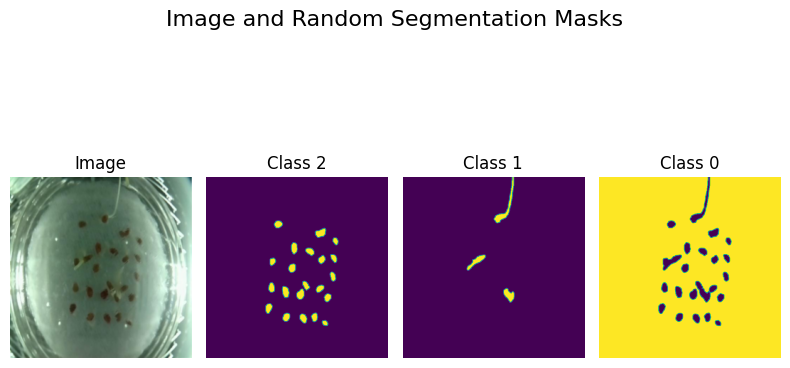

In [15]:
random_sample_visualization(dataset=train_dataset, num_classes=config["Number of classes"],
                            single_class=config['Single class train'],type='baseline')

In [16]:
wandb.login(key=config["Wandb monitoring"][0])
run = wandb.init()

# UNet - ResNet34 model
artifact = run.use_artifact('gcpds/MasterTests/best_model:v147', type='model')
artifact_dir = artifact.download()

# UNet - MobileNetV3 model
artifact = run.use_artifact('gcpds/MasterTests/best_model:v157', type='model')
artifact_dir = artifact.download()

# ResUNet - ResNet34 model
artifact = run.use_artifact('gcpds/MasterTests/best_model:v150', type='model')
artifact_dir = artifact.download()

# ResUNet - MobileNetV3 model
artifact = run.use_artifact('gcpds/MasterTests/best_model:v160', type='model')
artifact_dir = artifact.download()

# DeepLabV3+ - ResNet34 model
artifact = run.use_artifact('gcpds/MasterTests/best_model:v165', type='model')
artifact_dir = artifact.download()

# DeepLabV3+ - MobileNetV3 model
artifact = run.use_artifact('gcpds/MasterTests/best_model:v169', type='model')
artifact_dir = artifact.download()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: liturriago (gcpds) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact best_model:v147, 93.60MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.4 (39.2MB/s)
wandb:   1 of 1 files downloaded.  
wandb: Downloading large artifact best_model:v150, 96.01MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.9 (33.2MB/s)
wandb:   1 of 1 files downloaded.  
wandb: Downloading large artifact best_model:v165, 97.71MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.6 (38.0MB/s)
wandb:   1 of 1 files downloaded.  


In [18]:
# UNet - ResNet34
UNet_ResNet34_model = UNet(in_channels=config["Input size"][0],out_channels=config["Number of classes"], final_activation=config["Activation function"],backbone="resnet34")
state_dict = torch.load('./artifacts/best_model:v147/best_model.pt', weights_only=True)
UNet_ResNet34_model.load_state_dict(state_dict)
UNet_ResNet34_model.to(torch.device(config.get('Device', 'cpu')))
UNet_ResNet34_model.eval()

# UNet - MobileNetV3
UNet_MobileNetV3_model = UNet(in_channels=config["Input size"][0],out_channels=config["Number of classes"], final_activation=config["Activation function"],backbone="mobilenetv3")
state_dict = torch.load('./artifacts/best_model:v157/best_model.pt', weights_only=True)
UNet_MobileNetV3_model.load_state_dict(state_dict)
UNet_MobileNetV3_model.to(torch.device(config.get('Device', 'cpu')))
UNet_MobileNetV3_model.eval()

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 162MB/s]


UNet(
  (encoder): MobileNetV3Encoder(
    (layer0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
    )
    (layer1): Sequential(
      (0): InvertedResidual(
        (block): Sequential(
    

In [19]:
# ResUNet - ResNet34
ResUNet_ResNet34_model = ResUNet(in_channels=config["Input size"][0],out_channels=config["Number of classes"], final_activation=config["Activation function"],backbone="resnet34")
state_dict = torch.load('./artifacts/best_model:v150/best_model.pt', weights_only=True)
ResUNet_ResNet34_model.load_state_dict(state_dict)
ResUNet_ResNet34_model.to(torch.device(config.get('Device', 'cpu')))
ResUNet_ResNet34_model.eval()

# ResUNet - MobileNetV3
ResUNet_MobileNetV3_model = ResUNet(in_channels=config["Input size"][0],out_channels=config["Number of classes"], final_activation=config["Activation function"],backbone="mobilenetv3")
state_dict = torch.load('./artifacts/best_model:v160/best_model.pt', weights_only=True)
ResUNet_MobileNetV3_model.load_state_dict(state_dict)
ResUNet_MobileNetV3_model.to(torch.device(config.get('Device', 'cpu')))
ResUNet_MobileNetV3_model.eval()

ResUNet(
  (encoder): MobileNetV3Encoder(
    (layer0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
    )
    (layer1): Sequential(
      (0): InvertedResidual(
        (block): Sequential(
 

In [20]:
# DeepLabV3+ - ResNet34
DeepLabV3Plus_ResNet34_model = DeepLabV3Plus(in_channels=config["Input size"][0],out_channels=config["Number of classes"], final_activation=config["Activation function"],backbone="resnet34")
state_dict = torch.load('./artifacts/best_model:v165/best_model.pt', weights_only=True)
DeepLabV3Plus_ResNet34_model.load_state_dict(state_dict)
DeepLabV3Plus_ResNet34_model.to(torch.device(config.get('Device', 'cpu')))
DeepLabV3Plus_ResNet34_model.eval()

# DeepLabV3+ - MobileNetV3
DeepLabV3Plus_MobileNetV3_model = DeepLabV3Plus(in_channels=config["Input size"][0],out_channels=config["Number of classes"], final_activation=config["Activation function"],backbone="mobilenetv3")
state_dict = torch.load('./artifacts/best_model:v169/best_model.pt', weights_only=True)
DeepLabV3Plus_MobileNetV3_model.load_state_dict(state_dict)
DeepLabV3Plus_MobileNetV3_model.to(torch.device(config.get('Device', 'cpu')))
DeepLabV3Plus_MobileNetV3_model.eval()

DeepLabV3Plus(
  (encoder): MobileNetV3Encoder(
    (layer0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
    )
    (layer1): Sequential(
      (0): InvertedResidual(
        (block): Sequent

In [31]:
images, masks = next(iter(test_dataset))

images = images.to(torch.device(config.get('Device', 'cpu')))
masks = masks.to(torch.device(config.get('Device', 'cpu')))

In [32]:
with torch.no_grad():
  if config.get("AMixPre", False):
      with autocast(torch.device(config.get('Device', 'cpu')).type):
          UNet_ResNet34_pred = UNet_ResNet34_model(images)
          UNet_MobileNetV3_pred = UNet_MobileNetV3_model(images)
          ResUNet_ResNet34_pred = ResUNet_ResNet34_model(images)
          ResUNet_MobileNetV3_pred = ResUNet_MobileNetV3_model(images)
          DeepLabV3Plus_ResNet34_pred = DeepLabV3Plus_ResNet34_model(images)
          DeepLabV3Plus_MobileNetV3_pred = DeepLabV3Plus_MobileNetV3_model(images)
  else:
      UNet_ResNet34_pred = UNet_ResNet34_model(images)
      UNet_MobileNetV3_pred = UNet_MobileNetV3_model(images)
      ResUNet_ResNet34_pred = ResUNet_ResNet34_model(images)
      ResUNet_MobileNetV3_pred = ResUNet_MobileNetV3_model(images)
      DeepLabV3Plus_ResNet34_pred = DeepLabV3Plus_ResNet34_model(images)
      DeepLabV3Plus_MobileNetV3_pred = DeepLabV3Plus_MobileNetV3_model(images)

In [33]:
sample = 7
mask_tresh = np.where(masks[sample].cpu().numpy()>0.5,1,0)
mask = np.argmax(mask_tresh, axis=0)

# UNet_ResNet34
UNet_ResNet34_tresh = np.where(UNet_ResNet34_pred[sample].cpu().numpy()>0.5,1,0)
UNet_ResNet34_pred = np.argmax(UNet_ResNet34_tresh, axis=0)
# 0: clase 0, 1: error en clase 1 o 2, 2: acierto en clase 1 o 2
UNet_ResNet34_accuracy = np.where(mask == 0, 0, 
                                   np.where(UNet_ResNet34_pred == mask, 2, 1))

# UNet_MobileNetV3
UNet_MobileNetV3_tresh = np.where(UNet_MobileNetV3_pred[sample].cpu().numpy()>0.5,1,0)
UNet_MobileNetV3_pred = np.argmax(UNet_MobileNetV3_tresh, axis=0)
UNet_MobileNetV3_accuracy = np.where(mask == 0, 0, 
                                      np.where(UNet_MobileNetV3_pred == mask, 2, 1))

# ResUNet_ResNet34
ResUNet_ResNet34_tresh = np.where(ResUNet_ResNet34_pred[sample].cpu().numpy()>0.5,1,0)
ResUNet_ResNet34_pred = np.argmax(ResUNet_ResNet34_tresh, axis=0)
ResUNet_ResNet34_accuracy = np.where(mask == 0, 0, 
                                      np.where(ResUNet_ResNet34_pred == mask, 2, 1))

# ResUNet_MobileNetV3
ResUNet_MobileNetV3_tresh = np.where(ResUNet_MobileNetV3_pred[sample].cpu().numpy()>0.5,1,0)
ResUNet_MobileNetV3_pred = np.argmax(ResUNet_MobileNetV3_tresh, axis=0)
ResUNet_MobileNetV3_accuracy = np.where(mask == 0, 0, 
                                         np.where(ResUNet_MobileNetV3_pred == mask, 2, 1))

# DeepLabV3Plus_ResNet34
DeepLabV3Plus_ResNet34_tresh = np.where(DeepLabV3Plus_ResNet34_pred[sample].cpu().numpy()>0.5,1,0)
DeepLabV3Plus_ResNet34_pred = np.argmax(DeepLabV3Plus_ResNet34_tresh, axis=0)
DeepLabV3Plus_ResNet34_accuracy = np.where(mask == 0, 0, 
                                            np.where(DeepLabV3Plus_ResNet34_pred == mask, 2, 1))

# DeepLabV3Plus_MobileNetV3
DeepLabV3Plus_MobileNetV3_tresh = np.where(DeepLabV3Plus_MobileNetV3_pred[sample].cpu().numpy()>0.5,1,0)
DeepLabV3Plus_MobileNetV3_pred = np.argmax(DeepLabV3Plus_MobileNetV3_tresh, axis=0)
DeepLabV3Plus_MobileNetV3_accuracy = np.where(mask == 0, 0, 
                                               np.where(DeepLabV3Plus_MobileNetV3_pred == mask, 2, 1))

In [ ]:
UNet_MobileNetV3_accuracy.shape

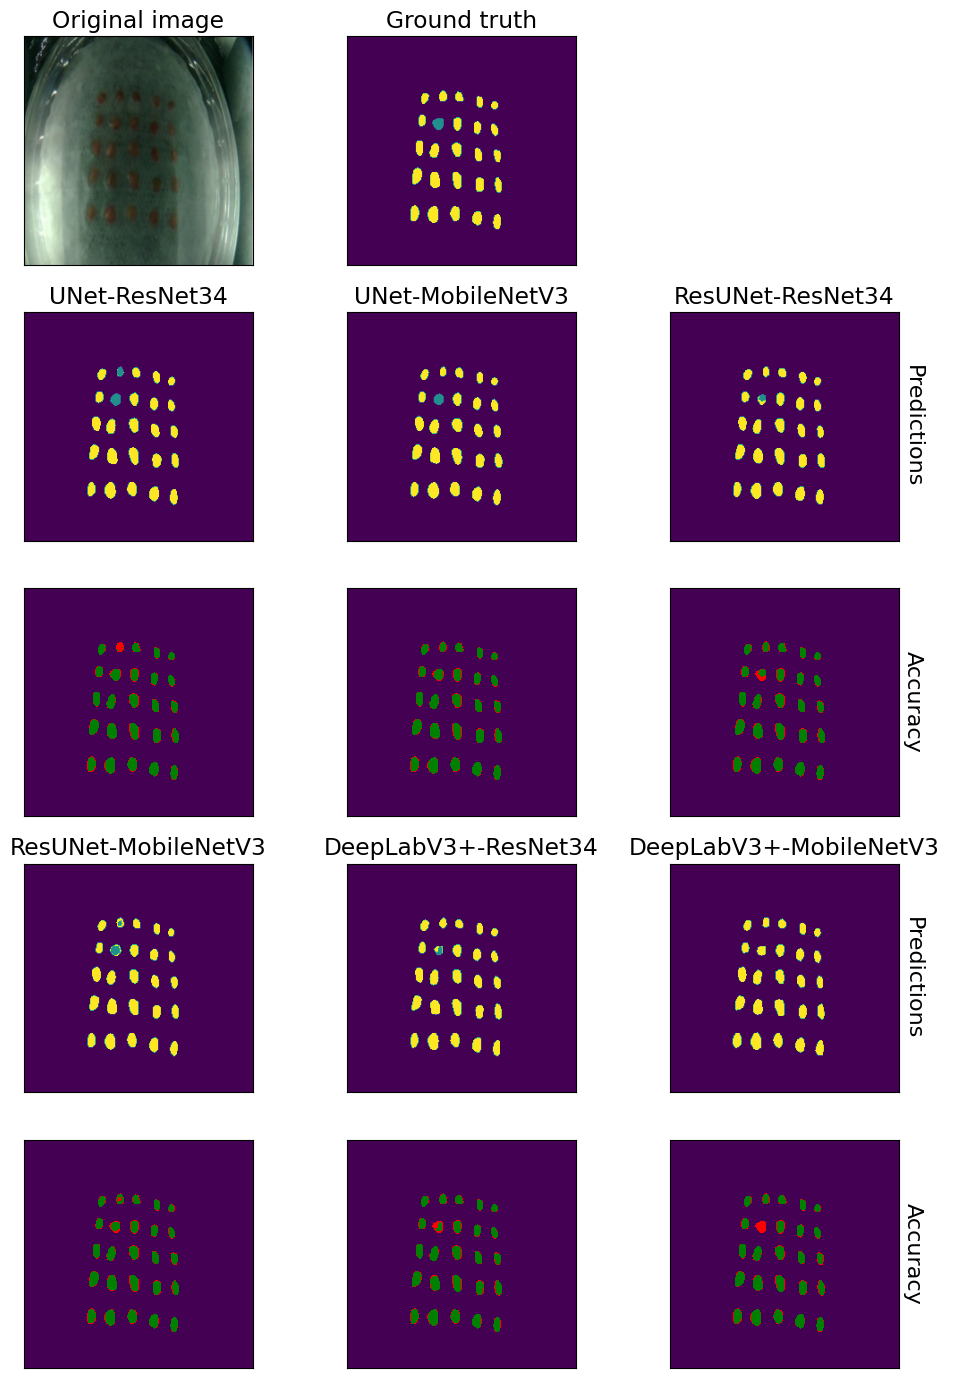

In [34]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# ----------  figura ----------
fig, axs = plt.subplots(5, 3, figsize=(10, 14))

# ----------  colormap ----------
# 0: clase 0 (morado), 1: error en clase 1/2 (rojo), 2: acierto en clase 1/2 (verde)
colors = ['#440154', 'red', 'green']
cmap = ListedColormap(colors)

plt.rcParams.update({'font.size': 14})

# =========================================================
# 0) ORIGINAL + GROUND-TRUTH
# =========================================================
axs[0, 0].imshow(images[sample].permute(1, 2, 0).cpu().numpy())
axs[0, 0].set_title('Original image')

axs[0, 1].imshow(mask)
axs[0, 1].set_title('Ground truth')

axs[0, 2].axis('off')

# =========================================================
# 1) PREDICCIONES  –––  fila 1
# =========================================================
axs[1, 0].imshow(UNet_ResNet34_pred)
axs[1, 0].set_title('UNet-ResNet34')

axs[1, 1].imshow(UNet_MobileNetV3_pred)
axs[1, 1].set_title('UNet-MobileNetV3')

axs[1, 2].imshow(ResUNet_ResNet34_pred)
axs[1, 2].set_title('ResUNet-ResNet34')

# =========================================================
# 2) ACCURACY      –––  fila 2
# =========================================================
axs[2, 0].imshow(UNet_ResNet34_accuracy, cmap=cmap, vmin=0, vmax=2)
axs[2, 1].imshow(UNet_MobileNetV3_accuracy, cmap=cmap, vmin=0, vmax=2)
axs[2, 2].imshow(ResUNet_ResNet34_accuracy, cmap=cmap, vmin=0, vmax=2)

# =========================================================
# 3) PREDICCIONES  –––  fila 3
# =========================================================
axs[3, 0].imshow(ResUNet_MobileNetV3_pred)
axs[3, 0].set_title('ResUNet-MobileNetV3')

axs[3, 1].imshow(DeepLabV3Plus_ResNet34_pred)
axs[3, 1].set_title('DeepLabV3+-ResNet34')

axs[3, 2].imshow(DeepLabV3Plus_MobileNetV3_pred)
axs[3, 2].set_title('DeepLabV3+-MobileNetV3')

# =========================================================
# 4) ACCURACY      –––  fila 4
# =========================================================
axs[4, 0].imshow(ResUNet_MobileNetV3_accuracy, cmap=cmap, vmin=0, vmax=2)
axs[4, 1].imshow(DeepLabV3Plus_ResNet34_accuracy, cmap=cmap, vmin=0, vmax=2)
axs[4, 2].imshow(DeepLabV3Plus_MobileNetV3_accuracy, cmap=cmap, vmin=0, vmax=2)

# ----------  quitar ticks ----------
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

# =========================================================
# 5) ETIQUETAS "Predictions / Accuracy" al final de cada fila
# =========================================================
def label_right(ax, text):
    """Pone `text` a la derecha del eje `ax`."""
    ax.annotate(text,
                xy=(1.02, 0.5), xycoords='axes fraction',
                rotation=270, va='center', ha='left',
                fontsize=16)

label_right(axs[1, 2], 'Predictions')   # fila 1
label_right(axs[2, 2], 'Accuracy')      # fila 2
label_right(axs[3, 2], 'Predictions')   # fila 3
label_right(axs[4, 2], 'Accuracy')      # fila 4

# ----------  layout y save ----------
plt.tight_layout()
fig.subplots_adjust(right=0.99)   # margen extra
fig.savefig('Models_predictions_5x3_labeled.pdf',
            dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()